## Semester 1 Project Submission

Please fill out:
* Student name: Prince
* Instructor name: Abhineet


### Importing Libraries

In [1]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
! cd ../..

### importing data CSV and SQLite DB

In [2]:
tn_budgets = pd.read_csv("../tn.movie_budgets.csv.gz")#../
bom = pd.read_csv('../../data/zippedData/bom.movie_gross.csv.gz')
rt_movie = pd.read_csv("../../data/zippedData/rt.movie_info.tsv.gz", sep='\t')
rt_reviews = pd.read_csv("../../data/zippedData/rt.reviews.tsv.gz", sep='\t', encoding='windows-1252')
tmdb = pd.read_csv("../../data/zippedData/tmdb.movies.csv.gz")
conn = sqlite3.connect('im.db')
cur = conn.cursor()
cur.execute("""SELECT name FROM sqlite_master WHERE type = 'table';""")
table_names = cur.fetchall()

## Data Cleaning

### replacing uncessary symbols in some strings, filling n/a's with 0

In [3]:
###drop currency and box office and studio columns??
bom['foreign_gross']= bom['foreign_gross'].str.replace(',','')
bom['foreign_gross'] = bom['foreign_gross'].fillna(0)
bom = bom.astype({'foreign_gross': float})
bom['domestic_gross'] = bom['domestic_gross'].fillna(0)
bom = bom[bom['studio'].notna()]
rt_reviews = rt_reviews[rt_reviews['rating'].notna()]
rt_reviews = rt_reviews[rt_reviews['review'].notna()]
rt_reviews = rt_reviews[rt_reviews['critic'].notna()]
rt_reviews = rt_reviews[rt_reviews['publisher'].notna()]

### clean rating column. ratings are out of 4, 5, 10, etc. Some have decimals, some shows /'s
### need to standardize ratings and turn to integers/floats

In [4]:
tn_budgets['release_date'] = pd.to_datetime(tn_budgets['release_date'])
tn_budgets['production_budget'] = tn_budgets['production_budget'].str.replace('$','')
tn_budgets['production_budget'] = tn_budgets['production_budget'].str.replace(',','')
tn_budgets = tn_budgets.astype({'production_budget': 'int64'})
tn_budgets['domestic_gross'] = tn_budgets['domestic_gross'].str.replace('$','')
tn_budgets['domestic_gross'] = tn_budgets['domestic_gross'].str.replace(',','')
tn_budgets = tn_budgets.astype({'domestic_gross': 'int64'})
tn_budgets['worldwide_gross'] = tn_budgets['worldwide_gross'].str.replace('$','')
tn_budgets['worldwide_gross'] = tn_budgets['worldwide_gross'].str.replace(',','')
tn_budgets = tn_budgets.astype({'worldwide_gross': 'int64'})

### Cleaning Studio columns to remove duplicates 

In [5]:
bom['studio'].unique()
bom['studio'] = bom['studio'].str.strip('()')
bom['studio'] = bom['studio'].str.strip('(NL')
bom['studio'] = bom['studio'].str.strip()
bom['studio'] = bom['studio'].str.strip()
bom['studio'] = bom['studio'].str.replace('BV','Walt Disney')
bom['studio'] = bom['studio'].str.replace('P/DW','Pixar')
bom['studio'] = bom['studio'].str.replace('Uni.','Universial')
bom['studio'] = bom['studio'].str.replace('Par.','Paramount')

In [6]:
bom['studio'] = bom['studio'].str.strip()

## Feature Creation & Data Merge 

In [7]:
## Adding a year column
tn_budgets['year'] =  pd.DatetimeIndex(tn_budgets['release_date']).year

In [8]:
### Merging bom dataframe and Tn budgets
bom_budgets = pd.merge(tn_budgets, bom[['studio','title', 'year']],left_on=['movie','year'], right_on = ['title','year'], how = 'inner')

In [9]:
### Creating a column called net that calculates the difference between worldwide_gross and production budget
bom_budgets['net'] = bom_budgets['worldwide_gross'] - bom_budgets['production_budget']

### Groups by studio and find the top ten Studio by net profit

In [10]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
net_studio = bom_budgets.groupby("studio")['net'].mean().to_frame(name = 'average_net').reset_index()
top10_studio = net_studio.sort_values(by=['average_net'], ascending= False, na_position='first').head(10)
#Reduces the amount of digits displayed
#top10_studio['average_net'] = top10_studio['average_net'] / 100

In [11]:
top10_studio

,studio,average_net
65,Pixar,374402760.100
90,Walt Disney,331044693.569
40,GrtIndia,233502914.000
84,Universial,180411604.539
31,Fox,172428262.183
77,Sony,170801300.014
88,WB,147744356.290
64,Paramount,128323855.627
50,MGM,96779636.000
83,UTV,95011597.000


In [12]:
bottom10_studio = net_studio.sort_values(by=['average_net'], ascending= True, na_position='first').head(10)

In [13]:
bottom10_studio

,studio,average_net
48,M,-31007708.000
33,Free,-25569338.667
46,KE,-17905047.000
55,OMNI/FSR,-13906275.000
12,BSC,-13263335.000
5,Amazon,-12965385.000
85,VE,-12139891.333
2,ATO,-10227814.000
4,Alc,-9838903.000
62,PH,-8917094.000


In [14]:
bom[bom['studio'] == 'BV']

,title,studio,domestic_gross,foreign_gross,year


In [15]:
tn_budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,2009
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,2019
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,2015
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017
...,...,...,...,...,...,...,...
5777,78,2018-12-31,Red 11,7000,0,0,2018
5778,79,1999-04-02,Following,6000,48482,240495,1999
5779,80,2005-07-13,Return to the Land of Wonders,5000,1338,1338,2005
5780,81,2015-09-29,A Plague So Pleasant,1400,0,0,2015


## Depicting the top ten studio by net revenue

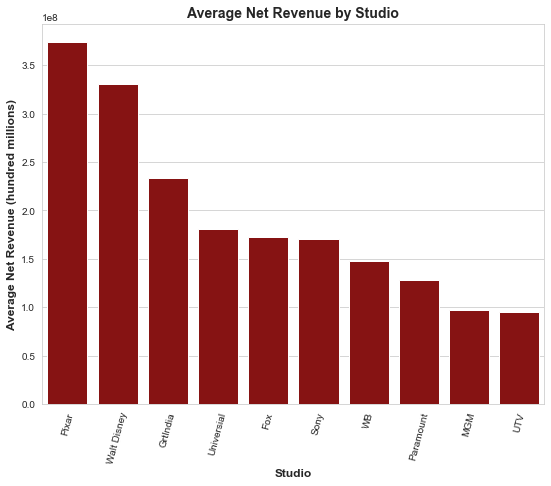

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plt.figure(figsize =(9,7))
ax = sns.barplot(data=top10_studio, x='studio', y='average_net',color='#990000' )

ax.set_title('Average Net Revenue by Studio', fontsize = 14, weight = 'bold')
ax.set_ylabel('Average Net Revenue (hundred millions)', fontsize = 12, weight = 'bold' )
ax.set_xlabel('Studio', fontsize = 12, weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=75);

plt.show()


## Creating bar graph of only studios with the lowest production cost

In [17]:
#grouping by studios by production cost
studio_cost = bom_budgets.groupby("studio")['production_budget'].mean().to_frame(name = 'average_cost').reset_index()
#creating_quartiles
studio_cost_qt = studio_cost['average_cost'].quantile([0.25, 0.5, 0.75])

In [18]:
# Selecting only studios in the 25th quartile or lower 
low_budget_studios = studio_cost[studio_cost['average_cost'] <= 6407142.857]
list_low = list(low_budget_studios['studio'])
low_cost_studios = bom_budgets[bom_budgets['studio'] == 'Viv' ]

In [19]:
for i in list_low:
    low_cost_studios = bom_budgets[bom_budgets['studio'] ==  i].append(low_cost_studios)

In [20]:
low_cost_studios

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,studio,title,net
1124,25,2010-04-09,Letters to God,3000000,2848587,3237452,2010,Viv.,Letters to God,237452
1188,58,2014-05-09,Palo Alto,1000000,767732,1156309,2014,Trib.,Palo Alto,156309
1029,87,2015-01-23,Song One,6000000,32251,437089,2015,TFA,Song One,-5562911
1095,22,2011-09-23,Red State,4000000,1065429,1983596,2011,SMod,Red State,-2016404
1028,71,2018-09-14,Mandy,6000000,1214525,1427656,2018,RLJ,Mandy,-4572344
1123,21,2016-04-22,Compadres,3000000,3127773,7445044,2016,PNT,Compadres,4445044
1102,52,2011-11-18,Another Happy Day,4000000,9120,978527,2011,P4,Another Happy Day,-3021473
1093,18,2012-08-24,Samsara,4000000,2672413,5966671,2012,Osci.,Samsara,1966671
1154,40,2011-04-08,Meek's Cutoff,2000000,977772,1869928,2011,Osci.,Meek's Cutoff,-130072
1139,25,2016-06-24,Hunt for the Wilderpeople,2500000,5205471,23845533,2016,Orch.,Hunt for the Wilderpeople,21345533


In [21]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
low_net_studio = low_cost_studios.groupby("studio")['net'].mean().to_frame(name = 'average_net').reset_index()
top10_low = low_net_studio.sort_values(by=['average_net'], ascending= False, na_position='first').head(10)

In [22]:
top10_low  

,studio,average_net
15,Orch.,21345533.000
13,MBox,12698355.000
1,Affirm,12235746.000
0,3D,11515203.000
3,BH Tilt,10437724.400
11,Jan.,7980196.000
18,PNT,4445044.000
7,GP,4328516.000
12,Kino,1721096.000
16,Osci.,918299.500


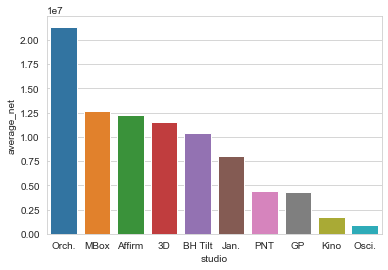

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=top10_low, x='studio', y='average_net')
plt.show()

In [24]:
bom_budgets['net'].describe()
low_cost_studios.describe()

,id,production_budget,domestic_gross,worldwide_gross,year,net
count,56.000,56.000,56.000,56.000,56.000,56.000
mean,45.946,4470892.857,2516423.964,6910763.500,2013.161,2439870.643
std,27.007,3992503.100,4656242.781,9786732.960,2.668,10593225.621
min,3.000,50000.000,0.000,7943.000,2010.000,-16380847.000
25%,24.750,2000000.000,214418.250,749145.000,2010.750,-2523633.750
50%,41.000,3875000.000,570220.000,2905844.500,2013.000,13118.500
75%,70.250,5000000.000,2918383.500,9752850.250,2015.250,4704379.750
max,98.000,18000000.000,25379975.000,57273049.000,2018.000,53273049.000


## Creating bar graph of only studios with the Highest production cost

In [25]:
qt_cost = studio_cost['average_cost'].quantile([0.25, 0.5, 0.75])
qt_cost

0.250    6203571.429
0.500   12250000.000
0.750   24873214.286
Name: average_cost, dtype: float64

In [26]:
high_budget_studios = studio_cost[studio_cost['average_cost'] >= qt_cost.iloc[2]]
list_high = list(high_budget_studios['studio'])
high_cost_studios = bom_budgets[bom_budgets['studio'] == 'Annapurna' ]

In [27]:
for i in list_high:
    high_cost_studios = bom_budgets[bom_budgets['studio'] ==  i].append(high_cost_studios)

In [28]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
high_net_studio = high_cost_studios.groupby("studio")['net'].mean().to_frame(name = 'average_net').reset_index()
top10_high = high_net_studio.sort_values(by=['average_net'], ascending= False, na_position='first').head(10)

In [29]:
top10_high

,studio,average_net
13,Pixar,374402760.100
23,Walt Disney,331044693.569
9,GrtIndia,233502914.000
21,Universial,180411604.539
5,Fox,172428262.183
17,Sony,170801300.014
22,WB,147744356.290
12,Paramount,128323855.627
11,MGM,96779636.000
19,Sum.,85736472.333


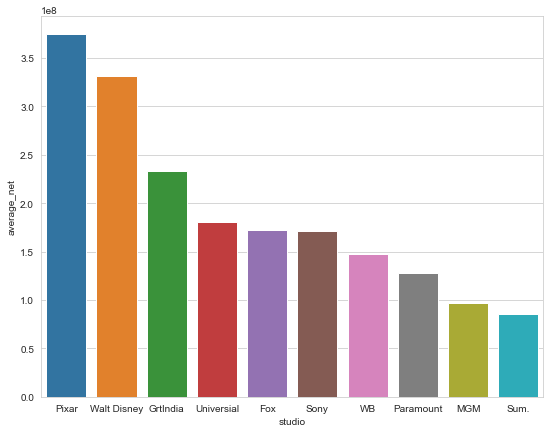

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize =(9,7))
sns.barplot(data=top10_high, x='studio', y='average_net')
plt.show()

## Creating a stat test

In [31]:
import scipy.stats as stats
from math import sqrt
x_bar = -2439870.643  # sample mean 
n = len(low_cost_studios['studio']) # number of students
sigma =  196291024.467 # sd of population
mu =  -107293864.594 # Population mean 

z = (x_bar - mu)/(sigma/sqrt(n))
z

3.99740866465819

In [ ]:
high_budget_studios['studio'].unique()

In [ ]:
stats.norm.cdf(z)

In [ ]:
pval = 1 - stats.norm.cdf(z)
pval